# Дисклеймер
Этот ноутбук был создан на основе ноутбука с лекции-семинара, все внесенные в него изменения связаны с реализацией наложения двух стилей с разными весами. Насколько поняла из домашки, материалами курса пользоваться не запрещалось. Сеть работает прекрасно, изначально хотела выбрать её для домашки, но засомневалась, что можно получить максимальный балл. Поэтому написала ещё и CycleGAN. Так что если так максисальный балл мне не светит - прошу обратиться к ноутбуку people2whitewalkers, да он и сам по себе забавный)

Нейронный перенос стиля с Pytorch
============================

Небольшое введение взятое с лекции-семинара:

**Нейронный перенос стиля** -- это алгоритм, который принимает контент-изображение (например, черепаху), стиль-изображение (например, картинку известного художника) и возвращает изображение, которое будто бы нарисовано тем художником:

**Как это работает?**

Всего есть три картинки: вход, стиль и контент. 
Определим два расстояния: 
- $D_S$ - оно определяет на сколько разные стили у двух произвольных картинок.
- $D_C$ - оно определяет на сколько разнится контент у двух произвольных картинок.

задача сети - минимизировать $D_S$ от входной картинки до стиля и $D_C$ от входной картиники до контента.<br />
В качестве входа обычно берется зашумленная к
артинка контента.


Позаботимся о необходимых нам версиях torchvision и pillow, установив их - перезапустите рантайм

In [1]:
!pip3 install torch torchvision
!pip3 install pillow==4.1.1

Ну и ещё самые разнообразные нужные нам библиотеки

In [0]:
%matplotlib inline
from PIL import Image
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import torchvision.models as models
import copy

Это необходимо только если вы работаете в колабе, запуская в jupyter notebook придётся внести некоторые изменеия в пути к файлам. А в колабе - просто создайте на google drive папку image и радуйтесь жизни

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


**Загрузка изображений**

Загрузим картинки и преобразуем их к одному размеру

In [0]:
imsize = 512

loader = transforms.Compose([
    transforms.Resize(imsize),  
    transforms.CenterCrop(imsize),
    transforms.ToTensor()]) 

In [0]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") #перенесём вычисления и данные на gpu
def image_loader(image_name):
    image = Image.open(image_name)
    image = loader(image).unsqueeze(0)
    return image.to(device, torch.float)

style1_img = image_loader("drive/My Drive/images/picasso.jpg")
style2_img = image_loader("drive/My Drive/images/starry.jpg")
content_img = image_loader("drive/My Drive/images/nking.jpg")

Глянем, то ли мы загрузили

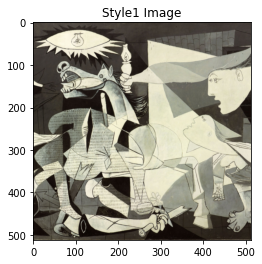

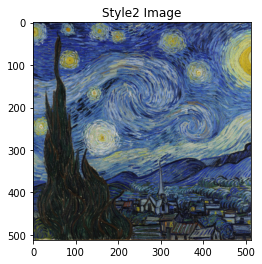

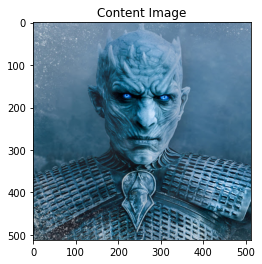

In [6]:
unloader = transforms.ToPILImage() 
plt.ion() 
def imshow(tensor, title=None):
    image = tensor.cpu().clone()   
    image = image.squeeze(0)      # функция для отрисовки изображения
    image = unloader(image)
    plt.imshow(image)
    if title is not None:
        plt.title(title)
    plt.pause(0.001) 

plt.figure()
imshow(style1_img, title='Style1 Image')

plt.figure()
imshow(style2_img, title='Style2 Image')

plt.figure()
imshow(content_img, title='Content Image')

Напишем функции, которые будут вычислять расстояния ( $D_C$ и $D_S$). <br />
Они будут выполенены в виде слоев, чтобы брать по ним автоградиент.

In [0]:
class ContentLoss(nn.Module):

        def __init__(self, target,):
            super(ContentLoss, self).__init__()
            self.target = target.detach()
            self.loss = F.mse_loss(self.target, self.target )

        def forward(self, input):
            self.loss = F.mse_loss(input, self.target)
            return input

Матрица грама позволяет учесть не только сами значения feature map'а, но и кореляцию фич друг с другом. <br /> Это нужно для того, чтобы сделать акцент на встречаемость фич с друг другом, а не на их геометрическом положении. <br />

$D_S$  = $\sum$($G_{ij}$($img_1$) - $G_{ij}$($img_2$)$)^{2}$

Сначала задаем спрособ подсчета матрицы грама: Это просто тензорное тензорное произведение вектора выхода уровня самого на себя.<br /> Однка наш выход - не вектор. В этом случае операция тоже возможна,<br /> но мы получим тензор третьего ранга. Поэтому перед перемножением выход нужно привести к форме вектора.<br />

In [0]:
def gram_matrix(input):
        batch_size , h, w, f_map_num = input.size()
        features = input.view(batch_size * h, w * f_map_num) 
        G = torch.mm(features, features.t())
        return G.div(batch_size * h * w * f_map_num)

Матрица грама готова, теперь нужно лишь реализовать MSE

In [0]:
class StyleLoss(nn.Module):
        def __init__(self, target_feature):
            super(StyleLoss, self).__init__()
            self.target = gram_matrix(target_feature).detach()
            self.loss = F.mse_loss(self.target, self.target)

        def forward(self, input):
            G = gram_matrix(input)
            self.loss = F.mse_loss(G, self.target)
            return input

При тренировке VGG каждое изображение на котором она обучалась было нормировано по всем каналам (RGB). Если мы хотим изпользовать ее для нашей модели, то мы должны реализовать нормировку и для наших изображений тоже.


In [0]:
cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406]).to(device)
cnn_normalization_std = torch.tensor([0.229, 0.224, 0.225]).to(device)

In [0]:
class Normalization(nn.Module):
        def __init__(self, mean, std):
            super(Normalization, self).__init__()
            # .view the mean and std to make them [C x 1 x 1] so that they can
            # directly work with image Tensor of shape [B x C x H x W].
            self.mean = torch.tensor(mean).view(-1, 1, 1)
            self.std = torch.tensor(std).view(-1, 1, 1)

        def forward(self, img):
            # normalize img
            return (img - self.mean) / self.std

Определим после каких уровней мы будем счиатать ошибки стиля, а после каких ошибки контента

In [0]:
content_layers_default = ['conv_4']
style_layers_default = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']

Определим предобученную модель

In [13]:
cnn = models.vgg19(pretrained=True).features.to(device).eval()

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/checkpoints/vgg19-dcbb9e9d.pth


In [0]:
def get_style_model_and_losses(cnn, normalization_mean, normalization_std,
                                   style1_img, style2_img, content_img,
                                   content_layers=content_layers_default,
                                   style_layers=style_layers_default):
        cnn = copy.deepcopy(cnn)

        # normalization module
        normalization = Normalization(normalization_mean, normalization_std).to(device)

        content_losses = []
        style1_losses = []
        style2_losses = []

        model = nn.Sequential(normalization)

        i = 0 
        for layer in cnn.children():
            if isinstance(layer, nn.Conv2d):
                i += 1
                name = 'conv_{}'.format(i)
            elif isinstance(layer, nn.ReLU):
                name = 'relu_{}'.format(i)
                #Переопределим relu уровень
                layer = nn.ReLU(inplace=False)
            elif isinstance(layer, nn.MaxPool2d):
                name = 'pool_{}'.format(i)
            elif isinstance(layer, nn.BatchNorm2d):
                name = 'bn_{}'.format(i)
            else:
                raise RuntimeError('Unrecognized layer: {}'.format(layer.__class__.__name__))

            model.add_module(name, layer)

            if name in content_layers:
                # add content loss:
                target = model(content_img).detach()
                content_loss = ContentLoss(target)
                model.add_module("content_loss_{}".format(i), content_loss)
                content_losses.append(content_loss)

            if name in style_layers:
                # add style loss:
                target_feature1 = model(style1_img).detach()
                style1_loss = StyleLoss(target_feature1)
                model.add_module("style1_loss_{}".format(i), style1_loss)
                style1_losses.append(style1_loss)

                target_feature2 = model(style2_img).detach()
                style2_loss = StyleLoss(target_feature2)
                model.add_module("style2_loss_{}".format(i), style2_loss)
                style2_losses.append(style2_loss)

        #выбрасываем все уровни после последенего styel loss или content loss
        for i in range(len(model) - 1, -1, -1):
            if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
                break

        model = model[:(i + 1)]

        return model, style1_losses, style2_losses, content_losses

In [0]:
def get_input_optimizer(input_img):
        #добоваляет содержимое тензора катринки в список изменяемых оптимизатором параметров
        optimizer = optim.LBFGS([input_img.requires_grad_()]) 
        return optimizer

closure - функция, которая вызывается во время каждого прохода, чтобы пересчитать loss. Без нее ничего не получется так как у нас своя функция ошибки

In [0]:
def run_style_transfer(cnn, normalization_mean, normalization_std,
                        content_img, style1_img, style2_img, input_img, num_steps=500,
                        style1_weight=70000, style2_weight=30000, content_weight=1):
  
        print('Building the style transfer model..')
        model, style1_losses, style2_losses, content_losses = get_style_model_and_losses(cnn,
            normalization_mean, normalization_std, style1_img, style2_img, content_img)
        optimizer = get_input_optimizer(input_img)

        print('Optimizing..')
        run = [0]
        while run[0] <= num_steps:

            def closure():
                # это для того, чтобы значения тензора картинки не выходили за пределы [0;1]
                input_img.data.clamp_(0, 1)

                optimizer.zero_grad()

                model(input_img)

                style1_score = 0
                style2_score = 0
                content_score = 0

                for sl1 in style1_losses:
                    style1_score += sl1.loss

                for sl2 in style2_losses:
                    style2_score += sl2.loss

                for cl in content_losses:
                    content_score += cl.loss
                
                #взвешивание ощибки
                style1_score *= style1_weight
                style2_score *= style2_weight
                content_score *= content_weight

                loss = style1_score + style2_score + content_score
                loss.backward(retain_graph=True)

                run[0] += 1
                if run[0] % 50 == 0:
                    print("run {}:".format(run))
                    print('Style1 Loss : {:4f} Style2 Loss : {:4f} Content Loss: {:4f}'.format(
                        style1_score.item(), style2_score.item(), content_score.item()))
                    print()

                return style1_score + style2_score + content_score

            optimizer.step(closure)

        # a last correction...
        input_img.data.clamp_(0, 1)

        return input_img

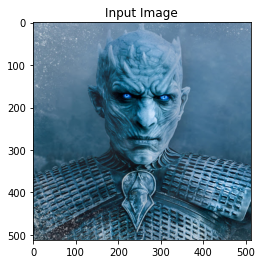

Building the style transfer model..
Optimizing..


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


run [50]:
Style1 Loss : 156.434540 Style2 Loss : 213.272308 Content Loss: 7.656418

run [100]:
Style1 Loss : 151.220139 Style2 Loss : 214.508774 Content Loss: 6.511724

run [150]:
Style1 Loss : 148.675766 Style2 Loss : 215.777420 Content Loss: 5.931353

run [200]:
Style1 Loss : 148.212021 Style2 Loss : 215.625244 Content Loss: 5.619559

run [250]:
Style1 Loss : 147.046387 Style2 Loss : 216.400452 Content Loss: 5.445774

run [300]:
Style1 Loss : 146.921997 Style2 Loss : 216.287170 Content Loss: 5.340105



In [21]:
input_img = content_img.clone()
plt.figure()
imshow(input_img, title='Input Image')
output = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
                            content_img, style1_img, style2_img, input_img, 300, 60000, 40000)

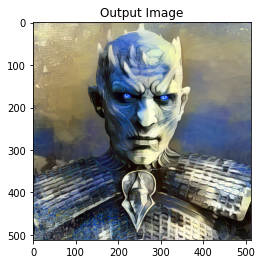

In [22]:
plt.figure()
imshow(output, title='Output Image')
plt.ioff()
plt.show()

Готово! Любуемся королём ночи из Игры Престолов в стиле Пикассо и Ван Гога
